In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time
import joblib
import os
import concurrent.futures

In [2]:
script_start = time.time()

print(Path.cwd())

dataset_path = Path.cwd().parent / "data" / "accepted_2007_to_2018Q4.csv"

# dataset_path = "accepted_2007_to_2018Q4.csv"

/users/ppalaniappan/Dissertation/Main


In [3]:
accepted_df = pd.read_csv(dataset_path)

/tmp/ipykernel_2133369/2428485555.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv(dataset_path)


In [4]:
accepted_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [5]:
# Find if there are any duplicate columns by loan id
duplicate_loan_id = accepted_df[accepted_df.duplicated('id', keep=False)]
print(duplicate_loan_id)

Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, fico_range_low, fico_range_high, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, last_fico_range_high, last_fico_range_low, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_act_il, open_il_12m, open_il_24m, mths_since_rcnt_i

In [6]:
accepted_df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [7]:
# Categroise loan_status into three broad categories
def map_loan_status(status):
    if status in ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']:
        return 0  # Good loan, no default
    elif status in ['Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period']:
        return 1  # Late / at risk 
    elif status in ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']:
        return 2  # Bad loan, defaulted
    else:
        return -1  # Missing or unknown status

accepted_df['loan_status_mapped'] = accepted_df['loan_status'].apply(map_loan_status)

counts = accepted_df['loan_status_mapped'].value_counts().sort_index()
percentages = accepted_df['loan_status_mapped'].value_counts(normalize=True).sort_index() * 100

summary_df = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})

print(summary_df)

                      Count  Percentage
loan_status_mapped                     
-1                       33    0.001460
 0                  1957056   86.568547
 1                    34252    1.515105
 2                   269360   11.914888


In [8]:
############################
# FICO - Loan status start
############################

fico_adjusted_df = accepted_df.dropna(subset=['fico_range_low', 'fico_range_high'])

fico_adjusted_df['fico_score'] = (fico_adjusted_df['fico_range_low'] + fico_adjusted_df['fico_range_high']) / 2


/tmp/ipykernel_2133369/3283222636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fico_adjusted_df['fico_score'] = (fico_adjusted_df['fico_range_low'] + fico_adjusted_df['fico_range_high']) / 2


In [9]:
fico_filtered_df = fico_adjusted_df[fico_adjusted_df['loan_status_mapped'].isin([0, 1, 2])]


/tmp/ipykernel_2133369/2637432810.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('FICO-Loan-Defalt-scatter-jitter.png', dpi=300, bbox_inches='tight')
/users/ppalaniappan/Dissertation/loan_new/lib64/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


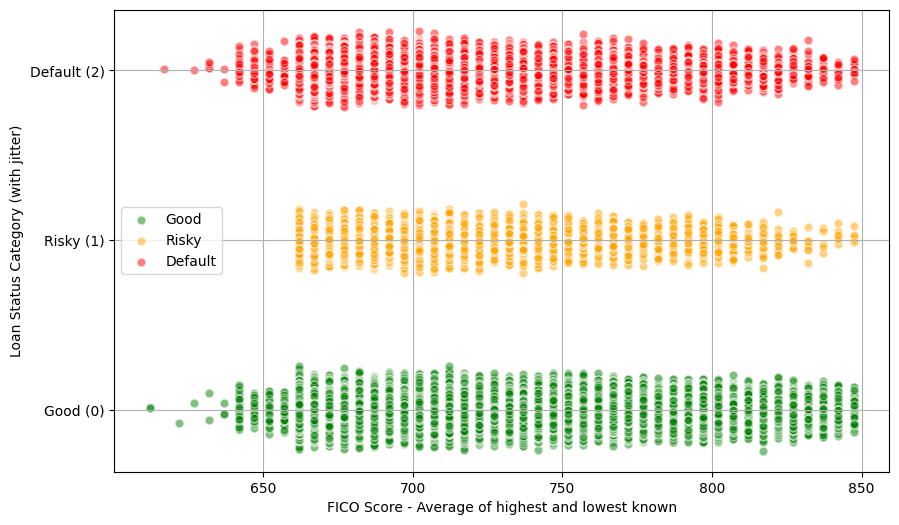

In [10]:

plt.figure(figsize=(10, 6))

colors = {0: 'green', 1: 'orange', 2: 'red'}
labels = {0: 'Good', 1: 'Risky', 2: 'Default'}

for status in [0, 1, 2]:
    subset = fico_filtered_df[fico_filtered_df['loan_status_mapped'] == status]
    
    y_jitter = status + np.random.normal(0, 0.05, size=len(subset))
    
    plt.scatter(subset['fico_score'],
                y_jitter,
                c=colors[status],
                label=labels[status],
                alpha=0.5,
                edgecolors='w',
                s=40)

plt.xlabel('FICO Score - Average of highest and lowest known')
plt.ylabel('Loan Status Category (with jitter)')
plt.yticks([0, 1, 2], ['Good (0)', 'Risky (1)', 'Default (2)'])
# plt.title('Scatter Plot of FICO Score vs Loan Status (with Jitter)')
plt.legend()
plt.grid(True)
plt.savefig('FICO-Loan-Defalt-scatter-jitter.png', dpi=300, bbox_inches='tight')
plt.show()

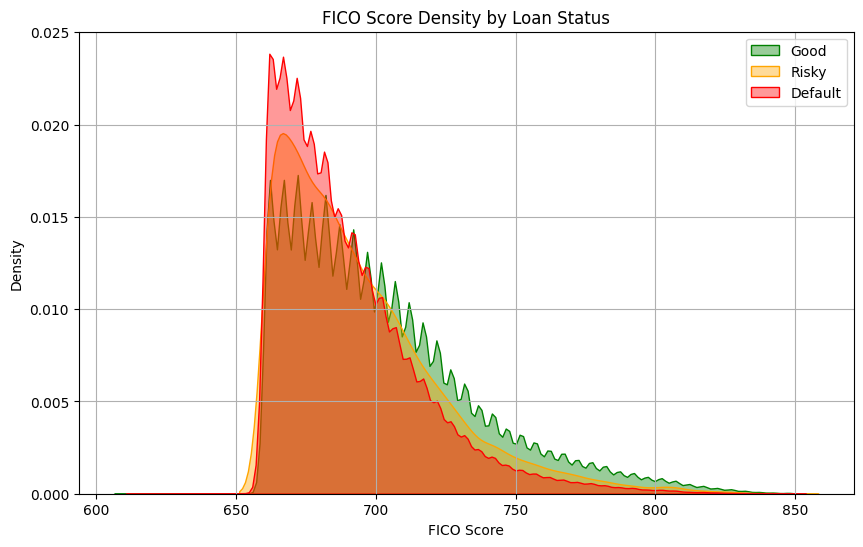

In [11]:
plt.figure(figsize=(10, 6))

colors = {0: 'green', 1: 'orange', 2: 'red'}
labels = {0: 'Good', 1: 'Risky', 2: 'Default'}

for status in [0, 1, 2]:
    subset = fico_filtered_df[fico_filtered_df['loan_status_mapped'] == status]
    sns.kdeplot(subset['fico_score'],
                label=labels[status],
                color=colors[status],
                fill=True,
                alpha=0.4)

plt.xlabel('FICO Score')
plt.ylabel('Density')
plt.title('FICO Score Density by Loan Status')
plt.legend()
plt.grid(True)
plt.savefig('FICO-Loan-Defalt-density.png', dpi=300, bbox_inches='tight')
plt.show()

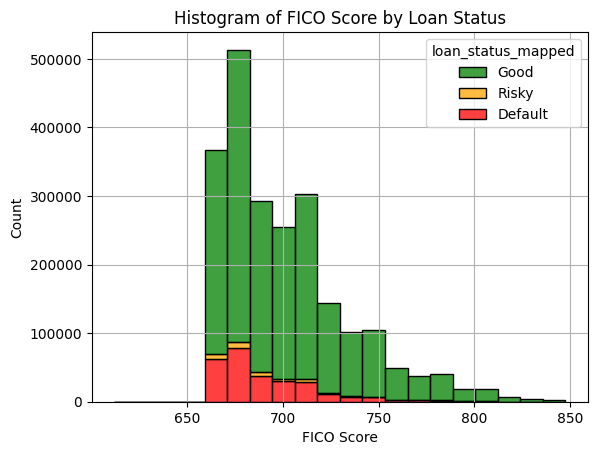

In [12]:
sns.histplot(
    data=fico_filtered_df,
    x='fico_score',
    hue='loan_status_mapped',
    palette=colors,
    bins=20,
    multiple='stack',
    edgecolor='black'
)

plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.title('Histogram of FICO Score by Loan Status')
plt.grid(True)

legend = plt.gca().get_legend()

if legend:
    label_map = {'0': 'Good', '1': 'Risky', '2': 'Default'}
    for text in legend.get_texts():
        if text.get_text() in label_map:
            text.set_text(label_map[text.get_text()])

plt.savefig('FICO-histogram', dpi=300, bbox_inches='tight')

plt.show()




In [13]:
def map_fico(fico_score):
    if fico_score < 580:
        return 'Poor'
    elif fico_score < 670:
        return 'Fair'
    elif fico_score < 740:
        return 'Good'
    elif fico_score < 800:
        return 'Very Good'
    else:
        return 'Exceptional'

fico_filtered_df['fico_category'] = fico_filtered_df['fico_score'].apply(map_fico)
    
fico_filtered_df['fico_category'].value_counts()



fico_category
Good           1610768
Fair            367828
Very Good       251024
Exceptional      31048
Name: count, dtype: int64

In [14]:
category_counts = fico_filtered_df.groupby(['fico_category', 'loan_status_mapped']).size().unstack(fill_value=0)

category_counts.columns = ['Good (0)', 'Risky (1)', 'Default (2)']

# Ensure FICO categories are in the desired order
fico_order = ['Fair', 'Good', 'Very Good', 'Exceptional']
category_counts = category_counts.reindex(fico_order)

# Map FICO categories to display names with ranges
fico_display_names = {
    'Fair': 'Fair (<670)',
    'Good': 'Good (670 to 739)',
    'Very Good': 'Very Good (740 to 799)',
    'Exceptional': 'Exceptional (>800)'
}
category_counts = category_counts.rename(index=fico_display_names)

# Calculate percentages row-wise
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Combine count and percentage in the same cell
combined = category_counts.astype(str) + " (" + category_percentages.round(2).astype(str) + "%)"

print(combined)

                                Good (0)      Risky (1)      Default (2)
fico_category                                                           
Fair (<670)              298093 (81.04%)    6991 (1.9%)   62744 (17.06%)
Good (670 to 739)       1393668 (86.52%)  24523 (1.52%)  192577 (11.96%)
Very Good (740 to 799)   235502 (93.82%)   2476 (0.99%)     13046 (5.2%)
Exceptional (>800)        29793 (95.96%)    262 (0.84%)       993 (3.2%)


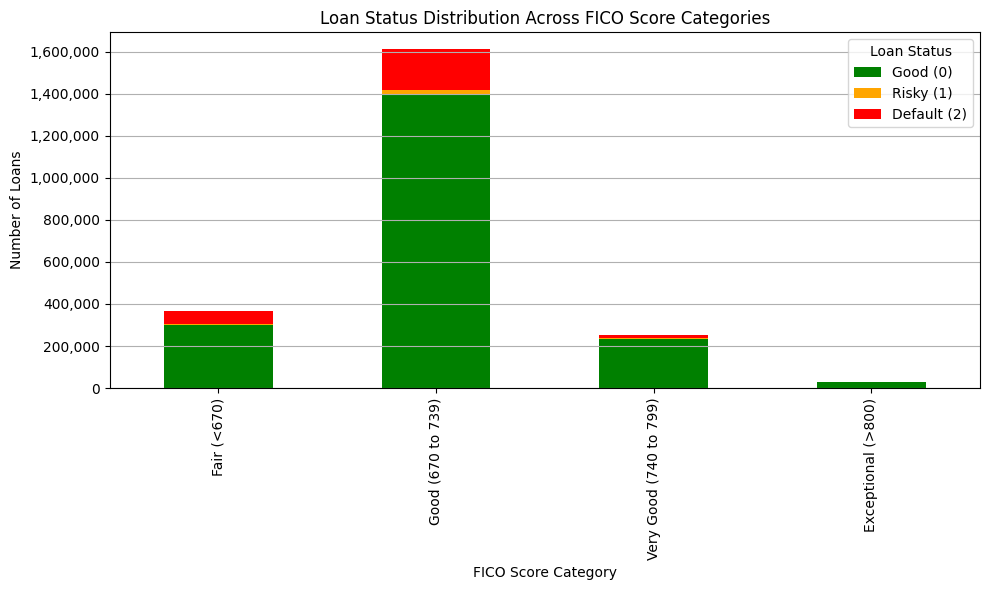

In [15]:
ax = category_counts.plot(kind='bar', stacked=True, figsize=(10, 6),
                          color=['green', 'orange', 'red'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Loan Status Distribution Across FICO Score Categories')
plt.xlabel('FICO Score Category')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Status')
plt.grid(axis='y')
plt.tight_layout()

plt.savefig('FICO-category-histogram', dpi=300, bbox_inches='tight')

plt.show()

########################
#FICO - Loan status End
########################

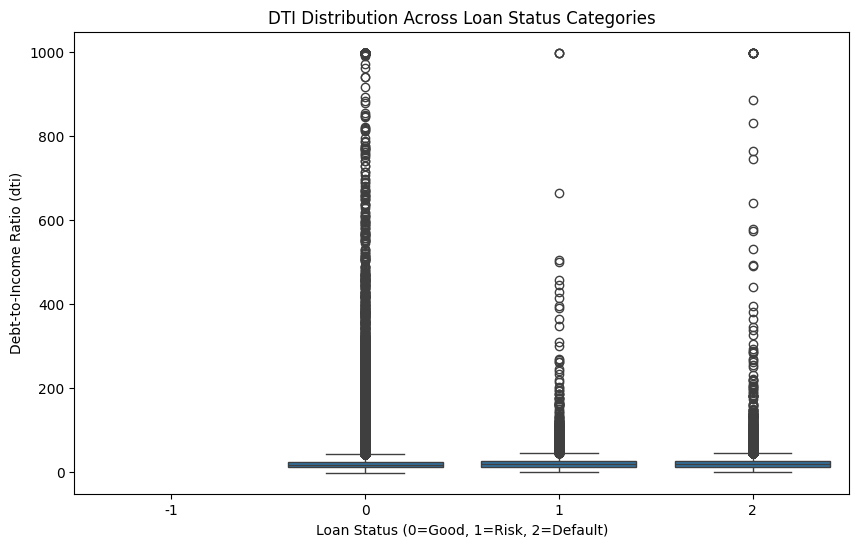

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x='loan_status_mapped', y='dti', data=accepted_df)
plt.xlabel('Loan Status (0=Good, 1=Risk, 2=Default)')
plt.ylabel('Debt-to-Income Ratio (dti)')
plt.title('DTI Distribution Across Loan Status Categories')
plt.savefig('FDTI Distribution Across Loan Status Categories', dpi=300, bbox_inches='tight')
plt.show()

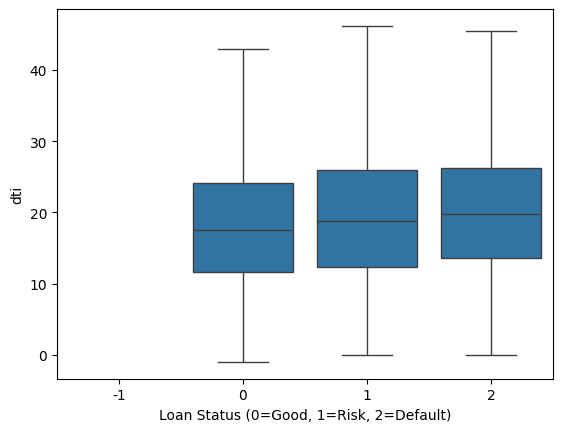

In [17]:
sns.boxplot(data=accepted_df, x='loan_status_mapped', y='dti', showfliers=False)
plt.xlabel('Loan Status (0=Good, 1=Risk, 2=Default)')
# plt.title("DTI by Loan Status (Outliers Hidden)")
plt.savefig('DTI by Loan Status (Outliers Hidden)', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
dti_outliers = accepted_df[accepted_df['dti'] > 100]

In [19]:
columns_to_view = ['annual_inc', 'loan_amnt', 'dti', 'installment','loan_status']
dti_outliers[columns_to_view].head(10)

,annual_inc,loan_amnt,dti,installment,loan_status
8721,1770.0,6550.0,999.00,236.34,Fully Paid
10548,20000.0,15000.0,137.40,531.44,Fully Paid
13700,17000.0,28000.0,136.97,714.07,Current
22841,27000.0,20000.0,100.09,510.05,Fully Paid
55648,8700.0,15000.0,120.66,523.00,Fully Paid
66461,5000.0,19000.0,380.53,472.10,Fully Paid
73833,1200.0,12000.0,672.52,445.91,Fully Paid
77957,9745.0,12000.0,125.25,303.81,Fully Paid
97333,12000.0,5000.0,104.00,170.87,Fully Paid
421565,2400.0,12000.0,296.50,372.40,Current


In [20]:
accepted_df['home_ownership'].value_counts()

home_ownership
MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: count, dtype: int64

In [21]:
home_ownership_df = accepted_df.groupby(['home_ownership','loan_status_mapped']).size().unstack(fill_value=0)

home_ownership_df.head(10)


loan_status_mapped,0,1,2
home_ownership,,,
ANY,915,25,56
MORTGAGE,981264,15290,114896
NONE,46,0,8
OTHER,144,0,38
OWN,218948,4188,29921
RENT,755739,14749,124441


In [22]:

home_ownership_df = accepted_df.groupby(['home_ownership', 'loan_status_mapped']).size().unstack(fill_value=0)


home_ownership_pct = home_ownership_df.div(home_ownership_df.sum(axis=1), axis=0) * 100


home_ownership_pct.round(2)


loan_status_mapped,0,1,2
home_ownership,,,
ANY,91.87,2.51,5.62
MORTGAGE,88.29,1.38,10.34
NONE,85.19,0.00,14.81
OTHER,79.12,0.00,20.88
OWN,86.52,1.65,11.82
RENT,84.45,1.65,13.91


In [23]:
accepted_df['emp_length'].unique()

array(['10+ years', '3 years', '4 years', '6 years', '1 year', '7 years',
       '8 years', '5 years', '2 years', '9 years', '< 1 year', nan],
      dtype=object)

In [24]:
def emp_duration_conversion(string_duration):
    if pd.isna(string_duration) or string_duration == '< 1 year':
        return 0
    elif string_duration == '10+ years':
        return 10
    else:
        return int(string_duration.split()[0])


accepted_df['emp_length_num'] = accepted_df['emp_length'].apply(emp_duration_conversion)
    

In [25]:
emp_loan_status = accepted_df.groupby(['emp_length_num', 'loan_status_mapped']).size().unstack(fill_value=0)

print(emp_loan_status)

loan_status_mapped  -1       0      1      2
emp_length_num                              
0                   33  287331   6118  43446
1                    0  127826   2287  18290
2                    0  176326   3146  24205
3                    0  156374   2816  21563
4                    0  118435   2212  15958
5                    0  121027   2126  16545
6                    0   88945   1498  12185
7                    0   79840   1203  11652
8                    0   78547   1232  12135
9                    0   68225   1012  10158
10                   0  654180  10602  83223


In [26]:
emp_loan_pct = emp_loan_status.div(emp_loan_status.sum(axis=1), axis = 0) * 100

emp_loan_pct.round(2)

loan_status_mapped,-1,0,1,2
emp_length_num,,,,
0,0.01,85.28,1.82,12.89
1,0.00,86.13,1.54,12.32
2,0.00,86.57,1.54,11.88
3,0.00,86.51,1.56,11.93
4,0.00,86.70,1.62,11.68
5,0.00,86.63,1.52,11.84
6,0.00,86.67,1.46,11.87
7,0.00,86.13,1.30,12.57
8,0.00,85.46,1.34,13.20


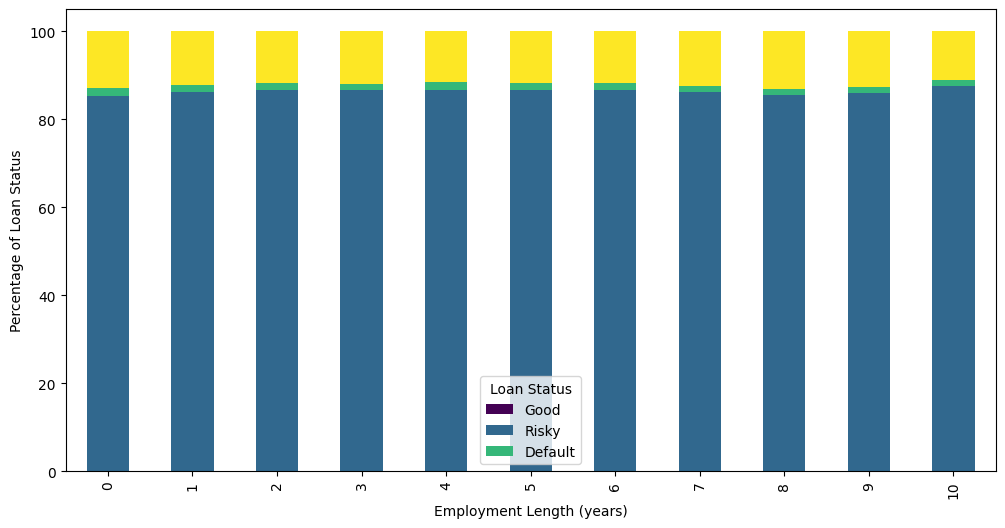

In [27]:
emp_loan_pct.plot(kind='bar', stacked=True, figsize=(12,6),
                        colormap='viridis')
# plt.title('Loan Status Percentage by Employment Length (years)')
plt.xlabel('Employment Length (years)')
plt.ylabel('Percentage of Loan Status')
plt.legend(['Good', 'Risky', 'Default'], title='Loan Status')
plt.savefig('Loan status By Employment Duration', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
title_counts = accepted_df['title'].value_counts(normalize=False)

In [29]:
each_title_percentage = title_counts/title_counts.sum()

cumulative_percent = each_title_percentage.cumsum()

top_titles = cumulative_percent[cumulative_percent <= 0.90].index

title_summary = pd.DataFrame({
    'count': title_counts[top_titles],
    'percentage': each_title_percentage[top_titles] * 100
})

print(title_summary)

title_wise_filtered = accepted_df[accepted_df['title'].isin(top_titles)]



                           count  percentage
title                                       
Debt consolidation       1153293   51.547461
Credit card refinancing   469691   20.993259
Home improvement          137437    6.142870
Other                     127714    5.708291
Major purchase             44840    2.004164
Medical expenses           25388    1.134739
Business                   20804    0.929853
Car financing              20526    0.917428


loan_status_mapped            0      1       2
title                                         
Business                  16670    518    3616
Car financing             18461    293    1772
Credit card refinancing  419541   6412   43738
Debt consolidation       989418  19691  144184
Home improvement         121353   2301   13783
Major purchase            39163    859    4818
Medical expenses          21901    445    3042
Other                    110868   2470   14376


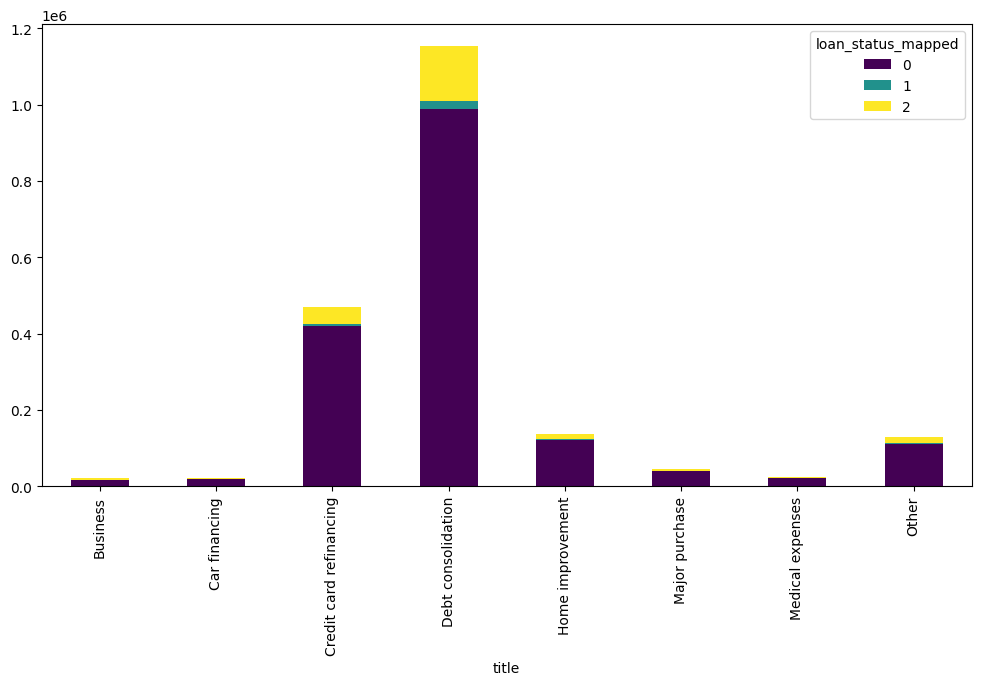

In [30]:
reasons_df = title_wise_filtered.groupby(['title', 'loan_status_mapped']).size().unstack(fill_value=0)

print(reasons_df)

reasons_df.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.savefig('Title(Top Reasons) vs Loan Status', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
## Loan application variables selection
## ## Removed addr_state it is huge after one hot encoding

selected_columns = [
    'loan_amnt',          # Loan amount requested
    'term',               # Loan term
    'installment',        # Monthly installment
    'sub_grade',          # More granular grade
    'emp_length',         # Employment length
    'home_ownership',     # Home ownership status
    'annual_inc',         # Annual income
    'verification_status',# Whether income was verified
    'purpose',            # Loan purpose
    'title',              # Loan title (user-defined purpose)
    'zip_code',           # Zip code (first 3 digits)
    # 'addr_state',         # State of residence
    'dti',                # Debt-to-income ratio
    'delinq_2yrs',        # Number of 30+ days past-due incidents in last 2 years
    'inq_last_6mths',     # Credit inquiries in past 6 months
    'open_acc',           # Number of open credit lines
    'pub_rec',            # Number of derogatory public records
    'revol_bal',          # Revolving credit balance
    'revol_util',         # Revolving line utilization rate (%)
    'total_acc',          # Total number of credit lines
    'application_type',   # Individual or joint application
    'fico_range_low',     # Observed Low FICO
    'fico_range_high',    # Observed High FICO
    'loan_status_mapped'  # Target variable: 0-good, 1-risk, 2-default
]

application_fields_df = accepted_df[selected_columns]

print(type(application_fields_df))

<class 'pandas.core.frame.DataFrame'>


In [32]:
application_fields_df.head(10)

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,title,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,fico_range_low,fico_range_high,loan_status_mapped
0,3600.0,36 months,123.03,C4,10+ years,MORTGAGE,55000.0,Not Verified,debt_consolidation,Debt consolidation,...,1.0,7.0,0.0,2765.0,29.7,13.0,Individual,675.0,679.0,0
1,24700.0,36 months,820.28,C1,10+ years,MORTGAGE,65000.0,Not Verified,small_business,Business,...,4.0,22.0,0.0,21470.0,19.2,38.0,Individual,715.0,719.0,0
2,20000.0,60 months,432.66,B4,10+ years,MORTGAGE,63000.0,Not Verified,home_improvement,NaN,...,0.0,6.0,0.0,7869.0,56.2,18.0,Joint App,695.0,699.0,0
3,35000.0,60 months,829.90,C5,10+ years,MORTGAGE,110000.0,Source Verified,debt_consolidation,Debt consolidation,...,0.0,13.0,0.0,7802.0,11.6,17.0,Individual,785.0,789.0,0
4,10400.0,60 months,289.91,F1,3 years,MORTGAGE,104433.0,Source Verified,major_purchase,Major purchase,...,3.0,12.0,0.0,21929.0,64.5,35.0,Individual,695.0,699.0,0
5,11950.0,36 months,405.18,C3,4 years,RENT,34000.0,Source Verified,debt_consolidation,Debt consolidation,...,0.0,5.0,0.0,8822.0,68.4,6.0,Individual,690.0,694.0,0
6,20000.0,36 months,637.58,B2,10+ years,MORTGAGE,180000.0,Not Verified,debt_consolidation,Debt consolidation,...,0.0,12.0,0.0,87329.0,84.5,27.0,Individual,680.0,684.0,0
7,20000.0,36 months,631.26,B1,10+ years,MORTGAGE,85000.0,Not Verified,major_purchase,Major purchase,...,0.0,8.0,0.0,826.0,5.7,15.0,Individual,705.0,709.0,0
8,10000.0,36 months,306.45,A2,6 years,RENT,85000.0,Not Verified,credit_card,Credit card refinancing,...,1.0,14.0,1.0,10464.0,34.5,23.0,Individual,685.0,689.0,0
9,8000.0,36 months,263.74,B5,10+ years,MORTGAGE,42000.0,Not Verified,credit_card,Credit card refinancing,...,0.0,8.0,0.0,7034.0,39.1,18.0,Individual,700.0,704.0,0


In [33]:
application_fields_df.head(10).to_csv('loan_application_data.csv', index=False)

In [34]:
applications_normalised_df = application_fields_df.drop(columns=['title', 'zip_code'])
print(type(applications_normalised_df))

<class 'pandas.core.frame.DataFrame'>


In [35]:
missing_percentage = applications_normalised_df.isna().mean() * 100
print(missing_percentage)

loan_amnt              0.001460
term                   0.001460
installment            0.001460
sub_grade              0.001460
emp_length             6.499754
home_ownership         0.001460
annual_inc             0.001637
verification_status    0.001460
purpose                0.001460
dti                    0.077144
delinq_2yrs            0.002743
inq_last_6mths         0.002787
open_acc               0.002743
pub_rec                0.002743
revol_bal              0.001460
revol_util             0.081170
total_acc              0.002743
application_type       0.001460
fico_range_low         0.001460
fico_range_high        0.001460
loan_status_mapped     0.000000
dtype: float64


In [36]:
applications_normalised_df['emp_length'] = applications_normalised_df['emp_length'].apply(emp_duration_conversion)

In [37]:
missing_percentage = applications_normalised_df.isna().mean() * 100
print(missing_percentage)

loan_amnt              0.001460
term                   0.001460
installment            0.001460
sub_grade              0.001460
emp_length             0.000000
home_ownership         0.001460
annual_inc             0.001637
verification_status    0.001460
purpose                0.001460
dti                    0.077144
delinq_2yrs            0.002743
inq_last_6mths         0.002787
open_acc               0.002743
pub_rec                0.002743
revol_bal              0.001460
revol_util             0.081170
total_acc              0.002743
application_type       0.001460
fico_range_low         0.001460
fico_range_high        0.001460
loan_status_mapped     0.000000
dtype: float64


In [38]:
applications_normalised_df.shape

(2260701, 21)

In [39]:
applications_normalised_df = applications_normalised_df.dropna()

In [40]:
applications_normalised_df.shape

(2257158, 21)

In [41]:
### Cleaning


# Term: map "36 months" -> 36, "60 months" -> 60
applications_normalised_df['term'] = applications_normalised_df['term'].str.extract('(\d+)').astype(int)


In [42]:
applications_normalised_df['term'].unique()

array([36, 60])

In [43]:
# Sub-grade: convert A1-G5 to ordinal number
sub_grade_order = {grade: i for i, grade in enumerate(
    ['A1','A2','A3','A4','A5',
     'B1','B2','B3','B4','B5',
     'C1','C2','C3','C4','C5',
     'D1','D2','D3','D4','D5',
     'E1','E2','E3','E4','E5',
     'F1','F2','F3','F4','F5',
     'G1','G2','G3','G4','G5']
)}

applications_normalised_df['sub_grade'] = applications_normalised_df['sub_grade'].map(sub_grade_order)

In [44]:
applications_normalised_df['sub_grade'].unique().shape

(35,)

In [45]:
categorical_cols = ['home_ownership', 'verification_status', 'purpose', 'application_type']

for col in categorical_cols:
    unique_vals = applications_normalised_df[col].unique()
    print(f"Unique values in '{col}': {unique_vals}\n")

Unique values in 'home_ownership': ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']

Unique values in 'verification_status': ['Not Verified' 'Source Verified' 'Verified']

Unique values in 'purpose': ['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']

Unique values in 'application_type': ['Individual' 'Joint App']



Unique values in 'application_type': ['Individual' 'Joint App']



In [46]:
applications_normalised_df = pd.get_dummies(applications_normalised_df, columns=categorical_cols, drop_first=True, dtype = 'int')

In [47]:
print(applications_normalised_df.head())

   loan_amnt  term  installment  sub_grade  emp_length home_ownership  \
0     3600.0    36       123.03         13          10       MORTGAGE   
1    24700.0    36       820.28         10          10       MORTGAGE   
2    20000.0    60       432.66          8          10       MORTGAGE   
3    35000.0    60       829.90         14          10       MORTGAGE   
4    10400.0    60       289.91         25           3       MORTGAGE   

   annual_inc verification_status             purpose    dti  ...  \
0     55000.0        Not Verified  debt_consolidation   5.91  ...   
1     65000.0        Not Verified      small_business  16.06  ...   
2     63000.0        Not Verified    home_improvement  10.78  ...   
3    110000.0     Source Verified  debt_consolidation  17.06  ...   
4    104433.0     Source Verified      major_purchase  25.37  ...   

   inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
0             1.0       7.0      0.0     2765.0        29.7       13.0  

In [48]:
## Fixing DTI

upper_limit = applications_normalised_df['dti'].quantile(0.99)

print(upper_limit)

applications_normalised_df['dti'] = applications_normalised_df['dti'].apply(lambda x: min(x, upper_limit))


42.71


In [49]:
print(applications_normalised_df['dti'].min())

print(applications_normalised_df['dti'].quantile(0.01))

lower_limit = applications_normalised_df['dti'].quantile(0.01)

applications_normalised_df['dti'] = applications_normalised_df['dti'].apply(lambda x: max(x, lower_limit))


-1.0
1.73


In [50]:
numerical_features = [
    'loan_amnt',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'fico_range_low',
    'fico_range_high'
]



In [51]:
print(applications_normalised_df['dti'].min())

1.73


In [52]:
print(applications_normalised_df['dti'].max())

42.71


In [53]:
for col in numerical_features:
    print(f'Column: {col}')
    min_value = applications_normalised_df[col].min()
    max_value = applications_normalised_df[col].max()
    print(f'  Min value - {min_value} , Max value - {max_value}')


Column: loan_amnt
  Min value - 500.0 , Max value - 40000.0
Column: installment
  Min value - 4.93 , Max value - 1719.83
Column: annual_inc
  Min value - 0.0 , Max value - 110000000.0
Column: dti
  Min value - 1.73 , Max value - 42.71
Column: delinq_2yrs
  Min value - 0.0 , Max value - 58.0
Column: inq_last_6mths
  Min value - 0.0 , Max value - 33.0
Column: open_acc
  Min value - 1.0 , Max value - 101.0
Column: pub_rec
  Min value - 0.0 , Max value - 86.0
Column: revol_bal
  Min value - 0.0 , Max value - 2904836.0
Column: revol_util
  Min value - 0.0 , Max value - 892.3
Column: total_acc
  Min value - 1.0 , Max value - 176.0
Column: fico_range_low
  Min value - 610.0 , Max value - 845.0
Column: fico_range_high
  Min value - 614.0 , Max value - 850.0


In [54]:
# Capping columns - 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util'

for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util']:
    cap = applications_normalised_df[col].quantile(0.99)
    applications_normalised_df[col] = np.where(
        applications_normalised_df[col] > cap, cap, applications_normalised_df[col]
    )

In [55]:
applications_normalised_df.shape

(2257158, 21)

In [57]:
applications_normalised_df['loan_status_binary'] = applications_normalised_df['loan_status_mapped'].replace({2:1})

applications_normalised_df['loan_status_binary'].unique()


applications_normalised_df.to_csv('data_selected.csv', index=False)

subset_df, _ = train_test_split(
    applications_normalised_df,
    train_size=1000,
    stratify=applications_normalised_df['loan_status_binary'],
    random_state=42
)

subset_df['loan_status_binary'].value_counts()

loan_status_binary
0    866
1    134
Name: count, dtype: int64

In [114]:
X = applications_normalised_df.drop(columns=['loan_status_mapped', 'loan_status_binary'])
y = applications_normalised_df['loan_status_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [117]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[1:10,:]

array([[-0.65831753, -0.63591105, -0.57662912, -0.83777316, -1.43005471,
        -1.17135561, -0.82612875, -0.40198122,  0.49751202, -0.819332  ,
        -0.4111629 , -0.77771641, -1.17266838, -1.01498815,  0.80027667,
         0.8002485 , -0.98301537, -0.00476509, -0.0086788 ,  2.81521006,
        -0.80969102, -0.80332585, -0.62145303, -0.5450436 ,  0.87696586,
        -0.01358114, -0.26715093, -0.07921039, -0.15091842, -0.11059137,
        -0.08296774, -0.25605215, -0.02511205, -0.10503225, -0.08284585,
        -0.03232634, -0.23598981],
       [-0.62294536, -0.63591105, -0.57689114, -0.99651553, -1.43005471,
        -0.63299543,  1.45527307, -0.40198122, -0.66554894,  0.60016098,
        -0.4111629 ,  0.97207753, -0.0975384 ,  0.57018192,  1.25478465,
         1.25474399,  1.01727809, -0.00476509, -0.0086788 , -0.35521328,
        -0.80969102, -0.80332585,  1.60913206,  1.83471561, -1.14029525,
        -0.01358114, -0.26715093, -0.07921039, -0.15091842, -0.11059137,
        -0.08296

In [60]:
def results_from_prediction(y_pred, y_test):
    confus_matrix = confusion_matrix(y_pred, y_test)
    total_predictions = confus_matrix.sum()
    correct_predictions = np.trace(confus_matrix)
    incorrect_predictions = total_predictions - correct_predictions
    error_rate = incorrect_predictions/total_predictions
    return error_rate, confus_matrix, classification_report(y_pred, y_test)
    

In [61]:
# Normal Knn with multiple values

# results = []

# for k in range(1,11):
#     print(f"Training KNN with k={k}...")
#     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     knn.fit(X_train_scaled, y_train)
#     y_pred = knn.predict(X_test_scaled)
#     error_rate, error_matrix, report = results_from_prediction(y_pred, y_test)
#     results.append({
#         'k': k,
#         'model': knn,
#         'error_rate': error_rate,
#         'confusion_matrix': error_matrix,
#         'classification_report': report
#     })

# knn_results_df = pd.DataFrame(results)



In [62]:
# Alternate with Grid Search

# param_grid = [
#     {
#         'n_neighbors': [6,8,10],
#         'weights': ['uniform', 'distance'],
#         'metric': ['minkowski'],
#         'p': [1, 2]
#     }
#     # ,
#     # {
#     #     'n_neighbors': [6,8,10],
#     #     'weights': ['uniform', 'distance'],
#     #     'metric': ['euclidean', 'manhattan']
#     # }
# ]

# knn = KNeighborsClassifier()
# grid_search = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)

# best_model = grid_search.best_estimator_  
# y_pred = best_model.predict(X_test_scaled)

# conf_matrix = confusion_matrix(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Calculate error rate
# total = conf_matrix.sum()
# correct = np.trace(conf_matrix)
# error_rate = (total - correct) / total

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Error rate: {error_rate:.4f}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(report)

In [63]:
# Knn search with more k values and other hyperparameter combination

os.makedirs("knn_models", exist_ok=True)

def run_knn(params):
    k, weights, metric, p, X_train, y_train, X_test, y_test = params
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric, p=p, n_jobs=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    error_rate, conf_matrix, report = results_from_prediction(y_test, y_pred)

    
    # Save the model
    model_name = f"knn_models/knn_k{k}_weights_{weights}_metric_{metric}_p{p}.joblib"
    joblib.dump(knn, model_name)
    
    return {
        'k': k,
        'weights': weights,
        'metric': metric,
        'p': p,
        'error_rate': error_rate,
        'classification_report_path': report,
        'confusion_matrix_path': conf_matrix
    }

# Prepare parameter grid manually
param_grid = []
for k in list(range(1,12)) + [20,50,100]:
    for weights in ['uniform', 'distance']:
        for metric in ['minkowski']:
            for p in [1, 2]:
                param_grid.append((k, weights, metric, p, X_train_scaled, y_train, X_test_scaled, y_test))

results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for res in executor.map(run_knn, param_grid):
        results.append(res)

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("knn_models/knn_results_summary.csv", index=False)


In [64]:
script_end = time.time()

print(f"It took {script_end - script_start:.2f} seconds")

It took 9324.96 seconds
